# Library

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import shap
import joblib

# 한글 글꼴 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 전처리

In [2]:
# 파일 불러오기
file_path = r"C:\Users\james\J_Data_Lab\Project-DonationPrediction\data\koweps_1010is.csv"
df = pd.read_csv(file_path)
df.head()

,h_cobf,h_reg5,h_reg7,h_din,h_cin,h_flag,h_hc,h01_1,h01_110,h_hc_all,...,h08_106_was_missing,h08_107_was_missing,h08_108_was_missing,h08_109_was_missing,h08_110_was_missing,h08_111_was_missing,h08_aq9_was_missing,h10_aq7_was_missing,h10_aq18_was_missing,h10_aq26_was_missing
0,0.0,1,1,858.8,896.0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1,0.0,1,1,1260.8,1310.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,0.0,1,1,2172.0,2208.0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0.0,1,1,864.0,864.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,0.0,1,1,1159.0,1171.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [3]:
df = df.drop(columns=['p_cp', 'h_g1'])

In [4]:
# 종속 변수
y = df['donation'].astype(int)

# 독립 변수
x = df.drop(columns=['p04_4', 'p04_5', 'donation'])

# 샘플링 및 모델링

In [5]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤 언더샘플링
ros = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

# 스케일링
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

In [6]:
# 모델 목록
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'MLP', 'CNN']

# 배깅과 교차 검증 설정
BAGS = 3
FOLDS = 3

# 결과 저장 리스트
results = []

# 특징 변수
FEATURES = x.columns.tolist()

for name in model_names:
    print(f'------{name}------')
    models_dict = {}  
    oof = np.zeros(len(y_train_resampled))

    if name == 'CNN':
        # (CNN 모델은 단일 학습)
        X_train_cnn = x_train_scaled.reshape(-1, x_train_scaled.shape[1], 1)
        X_test_cnn = x_test_scaled.reshape(-1, x_test_scaled.shape[1], 1)

        # CNN 모델 정의
        model = Sequential()
        model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # 조기 종료 콜백 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # 모델 학습
        model.fit(X_train_cnn, y_train_resampled, 
                  validation_split=0.2,
                  epochs=10, batch_size=64, verbose=1, callbacks=[early_stopping])

        # 훈련 세트 예측
        oof_preds = model.predict(X_train_cnn).flatten()
        final_predictions = (oof_preds > 0.5).astype(int)

        # 평가 지표
        accuracy = accuracy_score(y_train_resampled, final_predictions)
        precision = precision_score(y_train_resampled, final_predictions)
        recall = recall_score(y_train_resampled, final_predictions)
        f1 = f1_score(y_train_resampled, final_predictions)
        roc_auc = roc_auc_score(y_train_resampled, oof_preds)

        # Specificity
        cm = confusion_matrix(y_train_resampled, final_predictions)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)

        # 결과 저장 (훈련 세트)
        results.append({
            'Algorithm': name + ' (Train)',
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1-score': f1,
            'Accuracy': accuracy,
            'AUC': roc_auc
        })

        # 테스트 세트 예측
        test_preds = model.predict(X_test_cnn).flatten()
        test_final_predictions = (test_preds > 0.5).astype(int)

        # 평가 지표 (테스트 세트)
        test_accuracy = accuracy_score(y_test, test_final_predictions)
        test_precision = precision_score(y_test, test_final_predictions)
        test_recall = recall_score(y_test, test_final_predictions)
        test_f1 = f1_score(y_test, test_final_predictions)
        test_roc_auc = roc_auc_score(y_test, test_preds)

        # Specificity 계산 (테스트 세트)
        test_cm = confusion_matrix(y_test, test_final_predictions)
        tn, fp, fn, tp = test_cm.ravel()
        test_specificity = tn / (tn + fp)

        # 결과 저장 (테스트 세트)
        results.append({
            'Algorithm': name + ' (Test)',
            'Precision': test_precision,
            'Recall': test_recall,
            'Specificity': test_specificity,
            'F1-score': test_f1,
            'Accuracy': test_accuracy,
            'AUC': test_roc_auc
        })
    else:
        for bag in range(BAGS):
            print('#' * 25)
            print(f'### Bag {bag + 1}')
            print('#' * 25)
            models_dict[bag] = []
            skf = KFold(n_splits=FOLDS, shuffle=True, random_state=bag)
            for fold, (train_idx, valid_idx) in enumerate(skf.split(x_train_resampled, y_train_resampled)):
                print(f'=> Fold {fold + 1}, ', end='')

                # 다운샘플링
                y_fold_train = y_train_resampled.iloc[train_idx]
                RMV = y_fold_train[y_fold_train == 0].sample(
                    frac=0.7, random_state=bag * BAGS + fold).index.values
                train_idx_balanced = np.setdiff1d(train_idx, RMV)

                # 학습 데이터
                X_fold_train = x_train_scaled[train_idx_balanced]
                y_fold_train_balanced = y_train_resampled.iloc[train_idx_balanced]

                # 검증 데이터
                X_fold_valid = x_train_scaled[valid_idx]
                y_fold_valid = y_train_resampled.iloc[valid_idx]

                # 모델 
                if name == 'Logistic Regression':
                    clf = LogisticRegression(max_iter=1000)
                elif name == 'Random Forest':
                    clf = RandomForestClassifier()
                elif name == 'XGBoost':
                    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
                elif name == 'LightGBM':
                    clf = lgb.LGBMClassifier()
                elif name == 'CatBoost':
                    clf = CatBoostClassifier(verbose=0)
                elif name == 'MLP':
                    clf = MLPClassifier(max_iter=1000)
                else:
                    continue  

                # 모델 학습
                clf.fit(X_fold_train, y_fold_train_balanced)

                # OOF
                if hasattr(clf, "predict_proba"):
                    oof_preds = clf.predict_proba(X_fold_valid)[:, 1]
                else:
                    oof_preds = clf.decision_function(X_fold_valid)

                oof[valid_idx] += oof_preds

                models_dict[bag].append(clf)
            print()

        # OOF 예측값 평균화
        oof /= (BAGS)

        # 최종 OOF 예측값 이진화
        final_predictions = (oof > 0.5).astype(int)

        # 평가 지표 (훈련 세트)
        accuracy = accuracy_score(y_train_resampled, final_predictions)
        precision = precision_score(y_train_resampled, final_predictions)
        recall = recall_score(y_train_resampled, final_predictions)
        f1 = f1_score(y_train_resampled, final_predictions)
        roc_auc = roc_auc_score(y_train_resampled, oof)

        # Specificity
        cm = confusion_matrix(y_train_resampled, final_predictions)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)

        # 결과 저장 (훈련 세트)
        results.append({
            'Algorithm': name + ' (Train)',
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1-score': f1,
            'Accuracy': accuracy,
            'AUC': roc_auc
        })

        # 테스트 세트 예측
        test_preds = np.zeros(len(x_test_scaled))

        for bag in models_dict:
            for clf in models_dict[bag]:
                if hasattr(clf, "predict_proba"):
                    test_preds += clf.predict_proba(x_test_scaled)[:, 1]
                else:
                    test_preds += clf.decision_function(x_test_scaled)

        # 테스트 예측값 평균화
        test_preds /= (BAGS * FOLDS)

        # 테스트 예측 이진화
        test_final_predictions = (test_preds > 0.5).astype(int)

        # 평가 지표 (테스트 세트)
        test_accuracy = accuracy_score(y_test, test_final_predictions)
        test_precision = precision_score(y_test, test_final_predictions)
        test_recall = recall_score(y_test, test_final_predictions)
        test_f1 = f1_score(y_test, test_final_predictions)
        test_roc_auc = roc_auc_score(y_test, test_preds)

        # Specificity (테스트 세트)
        test_cm = confusion_matrix(y_test, test_final_predictions)
        tn, fp, fn, tp = test_cm.ravel()
        test_specificity = tn / (tn + fp)

        # 결과 저장 (테스트 세트)
        results.append({
            'Algorithm': name + ' (Test)',
            'Precision': test_precision,
            'Recall': test_recall,
            'Specificity': test_specificity,
            'F1-score': test_f1,
            'Accuracy': test_accuracy,
            'AUC': test_roc_auc
        })
results_df = pd.DataFrame(results)

------Logistic Regression------
#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, 
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, 
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, 
------Random Forest------
#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, 
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, 
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, 
------XGBoost------
#########################
### Bag 1
#########################
=> Fold 1, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 2, => Fold 3, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



#########################
### Bag 2
#########################
=> Fold 1, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 2, => Fold 3, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 3, 
------LightGBM------
#########################
### Bag 1
#########################
=> Fold 1, [LightGBM] [Info] Number of positive: 7711, number of negative: 7690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16960
[LightGBM] [Info] Number of data points in the train set: 15401, number of used features: 308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500682 -> initscore=0.002727
[LightGBM] [Info] Start training from score 0.002727
=> Fold 2, [LightGBM] [Info] Number of positive: 7634, number of negative: 7752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7316 - loss: 0.5483 - val_accuracy: 0.7394 - val_loss: 0.4993
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7950 - loss: 0.4669 - val_accuracy: 0.6402 - val_loss: 0.6146
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7945 - loss: 0.4630 - val_accuracy: 0.6387 - val_loss: 0.6446
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8004 - loss: 0.4505 - val_accuracy: 0.6385 - val_loss: 0.6203
742/742 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


In [7]:
test_results_df = results_df[results_df['Algorithm'].str.contains('\(Test\)')]
test_results_df

,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
1,Logistic Regression (Test),0.986199,0.751928,0.818335,0.853275,0.755564,0.869208
3,Random Forest (Test),0.988173,0.740546,0.846983,0.846624,0.746374,0.874456
5,XGBoost (Test),0.989077,0.765418,0.854061,0.862992,0.770271,0.887677
7,LightGBM (Test),0.988960,0.760732,0.853387,0.859961,0.765805,0.885196
9,CatBoost (Test),0.988728,0.760342,0.850354,0.859624,0.765270,0.885427
11,MLP (Test),0.985229,0.765672,0.801820,0.861684,0.767651,0.864200
13,CNN (Test),0.985396,0.737657,0.811257,0.843717,0.741687,0.856183


In [11]:
# 모델 저장
models_dict = {}
BAGS = 5
FOLDS = 5

# OOF
oof = np.zeros(len(y_train_resampled))

# XGBoost 
for bag in range(BAGS):
    print('#' * 25)
    print(f'### Bag {bag + 1}')
    print('#' * 25)
    models_dict[bag] = []  

    skf = KFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(x_train_resampled, y_train_resampled)):
        print(f'=> Fold {fold + 1}, ', end='')

        
        y_fold_train = y_train_resampled.iloc[train_idx]
        RMV = y_fold_train[y_fold_train == 0].sample(
            frac=0.7, random_state=bag * BAGS + fold).index.values
        train_idx_balanced = np.setdiff1d(train_idx, RMV)

        X_fold_train = x_train_scaled[train_idx_balanced]
        y_fold_train_balanced = y_train_resampled.iloc[train_idx_balanced]

        X_fold_valid = x_train_scaled[valid_idx]
        y_fold_valid = y_train_resampled.iloc[valid_idx]

        clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        clf.fit(X_fold_train, y_fold_train_balanced)

        oof_preds = clf.predict_proba(X_fold_valid)[:, 1]  # 확률 예측값 저장
        oof[valid_idx] += oof_preds

        models_dict[bag].append(clf)
    print()


oof /= (BAGS)
final_predictions = (oof > 0.5).astype(int)

accuracy = accuracy_score(y_train_resampled, final_predictions)
precision = precision_score(y_train_resampled, final_predictions)
recall = recall_score(y_train_resampled, final_predictions)
f1 = f1_score(y_train_resampled, final_predictions)
roc_auc = roc_auc_score(y_train_resampled, oof)
cm = confusion_matrix(y_train_resampled, final_predictions)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"훈련 세트 - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, AUC: {roc_auc}, Specificity: {specificity}")

# 최종 XGBoost 모델 저장 
best_xgb_model = models_dict[BAGS-1][-1] 
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')
print("저장완료: 'best_xgb_model.pkl'")

#########################
### Bag 1
#########################
=> Fold 1, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 2, => Fold 3, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 4, => Fold 5, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 3, => Fold 4, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 5, 
#########################
### Bag 3
#########################
=> Fold 1, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 2, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 3, => Fold 4, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 5, 
#########################
### Bag 4
#########################
=> Fold 1, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 2, => Fold 3, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 4, => Fold 5, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



#########################
### Bag 5
#########################
=> Fold 1, => Fold 2, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 3, => Fold 4, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=> Fold 5, 

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



훈련 세트 - Accuracy: 0.8056796157411309, Precision: 0.8331343557718799, Recall: 0.7644729080643802, F1: 0.7973281771840394, AUC: 0.8876634574818235, Specificity: 0.8468863234178815
XGBoost 모델이 저장되었습니다: 'best_xgb_model.pkl'


# 전체 기부특성 분석

In [12]:
best_xgb_model = joblib.load('best_xgb_model.pkl')

# 예측 수행
y_test_pred = best_xgb_model.predict(x_test_scaled)
y_test_proba = best_xgb_model.predict_proba(x_test_scaled)

# DataFrame 
test_results = pd.DataFrame(x_test_scaled, columns=x_test.columns)
test_results['Actual'] = y_test.reset_index(drop=True)  
test_results['Predicted'] = y_test_pred  
test_results['Donation_Probability'] = y_test_proba[:, 1]  

# 상위 10명 
top_donors = test_results.sort_values(by='Donation_Probability', ascending=False).head(10)

# 결과 출력
top_donors

,h_cobf,h_reg5,h_reg7,h_din,h_cin,h_flag,h_hc,h01_1,h01_110,h_hc_all,...,h08_109_was_missing,h08_110_was_missing,h08_111_was_missing,h08_aq9_was_missing,h10_aq7_was_missing,h10_aq18_was_missing,h10_aq26_was_missing,Actual,Predicted,Donation_Probability
42131,0.0,0.50,0.833333,0.160981,0.155361,1.0,1.0,0.500,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999977
3421,0.0,1.00,0.333333,0.173694,0.172333,1.0,1.0,0.625,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999973
9877,0.0,0.00,0.000000,0.179613,0.179307,1.0,1.0,0.375,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999970
18869,0.0,0.50,1.000000,0.159457,0.154216,1.0,1.0,0.500,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999969
33403,0.0,0.50,0.166667,0.168555,0.165929,1.0,1.0,0.500,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999969
26811,0.0,0.25,1.000000,0.157486,0.153046,1.0,1.0,0.375,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999962
36561,0.0,0.50,0.833333,0.152814,0.147530,1.0,0.0,0.500,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999960
28949,0.0,0.50,0.666667,0.150812,0.145823,1.0,0.0,0.250,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999959
3098,0.0,0.25,0.666667,0.186667,0.187205,1.0,0.0,0.500,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999958
19067,0.0,0.25,1.000000,0.156256,0.152364,1.0,1.0,0.375,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999958


# SHAP 분석

In [13]:
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# 변수 매핑
variable_mapping = {
    'h_eco1': '가구원번호',
    'h_soc_13': '건강보험 가입여부',
    'h_g6': '교육수준',
    'h_eco4': '주된 경제활동 참여상태',
    'h_med8': '건강검진 횟수',
    'h_g4': '태어난 연도',
    'h_med2': '건강상태',
    'h_g2': '가구주와의 관계',
    'h01_1': '가구원수',
    'h_g11': '종교',
    'p03_1': '인터넷 사용 여부',
    'p03_11': '여가생활만족도',
    'h_cin': '경상소득',
    'p05_26': '나에 대해 대체로 만족',
    'h_inc2_1': '상용근로자 해당여부',
    'p05_20': '나는 가치 있는 사람',
    'p05_25': '긍정적인 태도',
    'h07_3aq13': '기타소비지출',
    'h07_9': '총생활비',
    'h07_4': '세금',
    'h07_3aq11': '교양오락비',
    'h07_6aq6': '종교관련비(십일조)',
    'h07_5': '사회보장부담금',
    'h05_3aq2': '민간의료보험의 12월 기준 보험료',
    'h07_5aq1': '식료품비 - 주류 및 담배',
    'h08_6aq3': '세금환급금',
    'h10_aq7': '금융자산-적금',
    'p03_9': '직업 만족도',
    'h08_aq9': '이자, 배당금, 연간소득',
    'h10_27': '소유한 자동차 가격',
    'h08_aq34': '민간 개인 또는 단체로 부터 받은 보조금',
    'h17_1': '1년간 근심이나 갈등을 초래한 문제',
    'h07_3aq9': '교육비-공교육비',
    'h07_6aq7': '세금-소득세',
    'h07_6aq14': '사회보장부담-고용보험료',
    'h07_6aq13': '사회보장부담-건강보험료',
    'h06_4': '(주택)방수',
    'h07_3aq15': '부모에게 보낸 월평금 송금보조비',
    'h07_6aq8': '재산세',
    'h07_6aq1': '광열수도비- 난방비',
    'p_cp': '최종조사결과 확인',
    'h_g1': '가구원 번호',
    'h_g7': '교육수준2',
    'h07_3aq7': '피복신발비',
    'h_g3': '성별',
    'p02_1': '근로유형',
    'h_med10': '민간의료보험 가입건수',
    'h_soc_2': '공적연금가입형태',
    'p03_6': '가족의 수입 만족도',
    'h_g10': '혼인상태',
    'h_reg5': '5개 권역별 지역구분',
    'h_med1': '가구원번호'
}

x_test_scaled_df.rename(columns=variable_mapping, inplace=True)

In [15]:
feature_names = x_test_scaled_df.columns.tolist()
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(x_test_scaled)

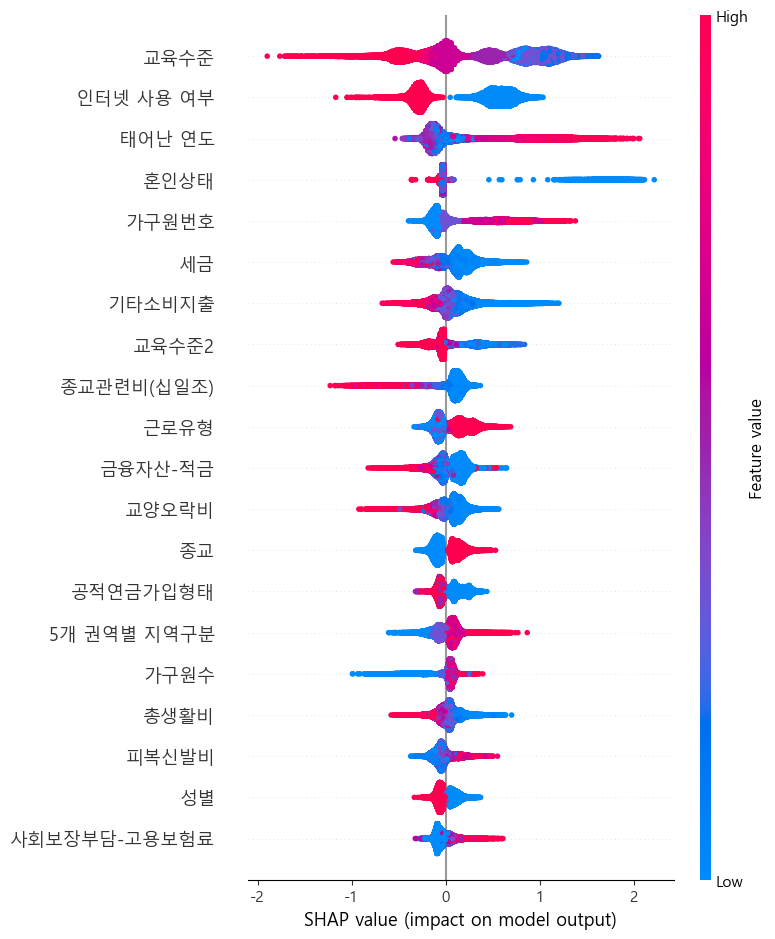

In [16]:
# SHAP Summary Plot
shap.summary_plot(shap_values, x_test_scaled, feature_names=feature_names)

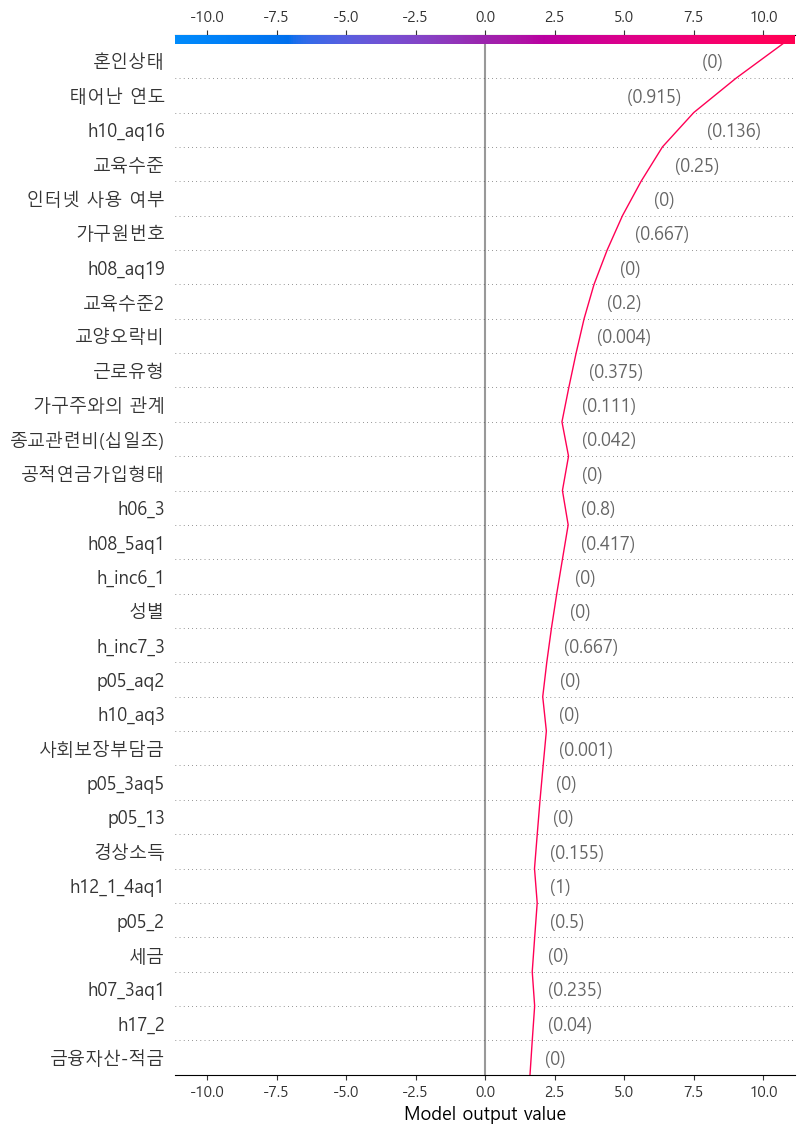

In [17]:
instance_index = 42131  #인덱스

shap.decision_plot(
    base_value=explainer.expected_value,  
    shap_values=shap_values[instance_index],  
    features=x_test_scaled_df.iloc[instance_index],  
    feature_names=feature_names,  
    feature_display_range=slice(None, -31, -1)  
)


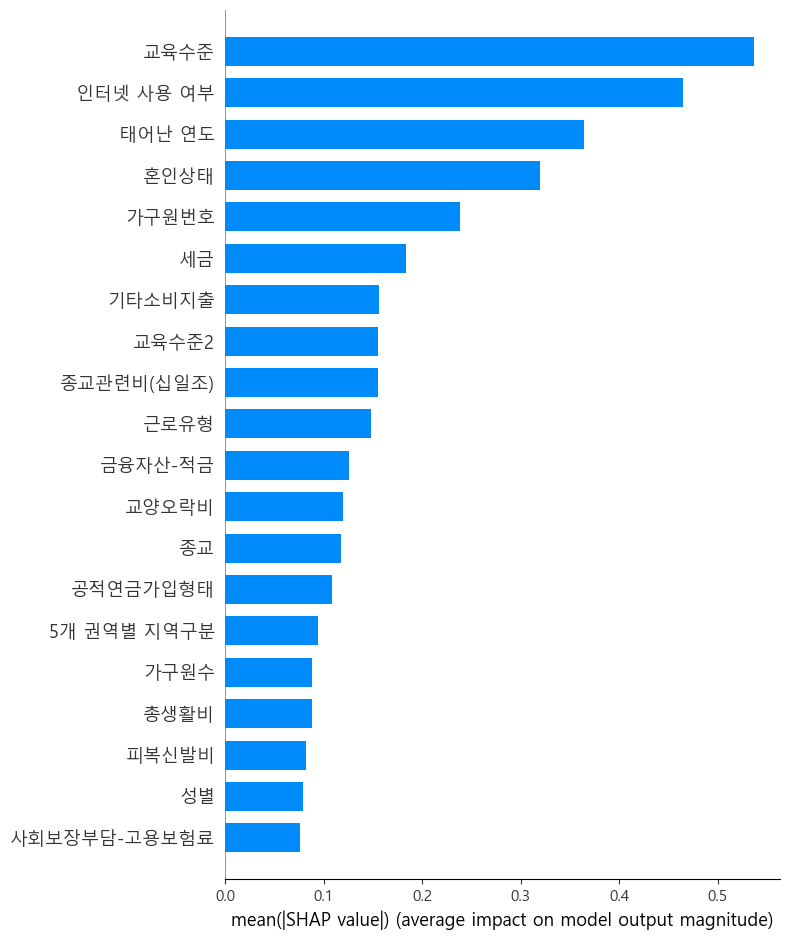

In [18]:
# 중요도 막대 그래프 
shap.summary_plot(shap_values, x_test_scaled, feature_names=feature_names, plot_type="bar")